## Import bibliotek i ładowanie danych

In [81]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import timeit

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 10

In [82]:
airline_test = pd.read_csv("./data/airline_passenger_satisfaction/test.csv")
airline_train = pd.read_csv("./data/airline_passenger_satisfaction/train.csv")

In [146]:
cars = pd.read_csv("./data/car_prices_poland/Car_Prices_Poland.csv")

In [147]:
miasta = pd.read_csv("./data/car_prices_poland/miasta.csv")

## Dataset `airline_passenger_satisfaction`

### Obróbka danych

In [236]:
airline_train.shape

(103904, 25)

In [237]:
airline_test.shape

(25976, 25)

Zbiór danych jest podzielony w stosunku 4:1.

In [238]:
airline_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [239]:
airline_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Sprawdzam rozkłady zmiennych tekstowych.

In [240]:
airline_train['satisfaction'].value_counts()

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64

Zmienną objaśnianą w naszym przypadku będzie `satisfaction`. Ma dwie różne wartości, więc naszym zadaniem będzie klasyfikacja.

In [241]:
airline_train['Customer Type'].value_counts()

Loyal Customer       84923
disloyal Customer    18981
Name: Customer Type, dtype: int64

In [242]:
airline_train['Type of Travel'].value_counts()

Business travel    71655
Personal Travel    32249
Name: Type of Travel, dtype: int64

In [243]:
airline_train['Class'].value_counts()

Business    49665
Eco         46745
Eco Plus     7494
Name: Class, dtype: int64

In [244]:
np.abs(airline_train['Arrival Delay in Minutes'] - airline_train['Departure Delay in Minutes']).mean()

4.973859489931849

In [245]:
# koduję zmienne tekstowe
# zmienne binarne koduję zero-jedynkowo
airline_train['satisfaction'] = (airline_train['satisfaction'] == 'satisfied') * 1
airline_train['Customer Type'] = (airline_train['Customer Type'] == 'Loyal Customer') * 1
airline_train['Type of Travel'] = (airline_train['Type of Travel'] == 'Business travel') * 1
airline_train['Gender'] = (airline_train['Gender'] == 'female') * 1
# zmienną Class koduję 0-1-2 w zależności od ceny, im niżej, tym taniej
airline_train['Class'] = airline_train['Class'].map({'Business' : 2, 'Eco Plus' : 1, 'Eco' : 0})

# zastępuję braki danych w kolumnie 'Arrival Delay in Minutes' wartościami z kolumny 'Departure Delay in Minutes',
# bo w większości są bardzo zbliżone
airline_train.loc[airline_train['Arrival Delay in Minutes'].isna(),'Arrival Delay in Minutes'] = airline_train['Departure Delay in Minutes']

# zmienne 'Unnamed : 0' i 'id' nie niosą ze sobą żadnej wartości, więc można się ich pozbyć
airline_train = airline_train.drop(['Unnamed: 0', 'id'], axis = 1)

# skaluję zmienne przyjmujące wiele różnych wartości
for col in ['Age','Flight Distance','Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    transf = airline_train[col].values.reshape(-1,1)
    scaler = StandardScaler().fit(transf)
    airline_train[col] = scaler.transform(transf)

In [246]:
# podobnie przekształcam zbiór walidacyjny
airline_test['satisfaction'] = (airline_test['satisfaction'] == 'satisfied') * 1
airline_test['Customer Type'] = (airline_test['Customer Type'] == 'Loyal Customer') * 1
airline_test['Type of Travel'] = (airline_test['Type of Travel'] == 'Business travel') * 1
airline_test['Gender'] = (airline_test['Gender'] == 'female') * 1

airline_test['Class'] = airline_test['Class'].map({'Business' : 2, 'Eco Plus' : 1, 'Eco' : 0})

airline_test.loc[airline_test['Arrival Delay in Minutes'].isna(),'Arrival Delay in Minutes'] = airline_test['Departure Delay in Minutes']

airline_test = airline_test.drop(['Unnamed: 0', 'id'], axis = 1)

for col in ['Age','Flight Distance','Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    transf = airline_test[col].values.reshape(-1,1)
    scaler = StandardScaler().fit(transf)
    airline_test[col] = scaler.transform(transf)

### Random forest

In [247]:
airline_train = airline_train[['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']]
airline_test = airline_test[['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']]

In [248]:
airline_train_y = airline_train['satisfaction']
airline_train_x = airline_train.drop('satisfaction', axis = 1)
airline_test_y = airline_test['satisfaction']
airline_test_x = airline_test.drop('satisfaction', axis = 1)

#### Wpływ `n_estimators` na wynik

In [249]:
rf = RandomForestClassifier(
                            n_estimators = 100,
                            max_depth = None,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

rf = RandomForestClassifier(
                            n_estimators = 10,
                            max_depth = None,
                            random_state = 17)

print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

rf = RandomForestClassifier(
                            n_estimators = 500,
                            max_depth = None,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

rf = RandomForestClassifier(
                            n_estimators = 1000,
                            max_depth = None,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

0.7631659993840468
0.7556975669849092
0.7634739759778257
0.7629350169387127


#### Wpływ `max_depth` na wynik

In [250]:
rf = RandomForestClassifier(
                            n_estimators = 100,
                            max_depth = None,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

rf = RandomForestClassifier(
                            n_estimators = 100,
                            max_depth = 2,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

rf = RandomForestClassifier(
                            n_estimators = 100,
                            max_depth = 8,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

rf = RandomForestClassifier(
                            n_estimators = 100,
                            max_depth = 14,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

rf = RandomForestClassifier(
                            n_estimators = 100,
                            max_depth = 20,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

0.7631659993840468
0.7708269171542963
0.7991222667077302
0.8014705882352942
0.7959270095472744


#### Wybór najlepszego zestawu parametrów – `n_estimators`=100, `max_depth`=14

In [266]:
rf = RandomForestClassifier(
                            n_estimators = 500,
                            max_depth = 14,
                            random_state = 17)
print(rf.fit(airline_train_x, airline_train_y).score(airline_test_x, airline_test_y))

0.8012781028641823


Otrzymany score faktycznie jest najlepszym z dotychczas obliczonych. Widać jednak, że liczba estymatorów powyżej pewnej granicy nie zmienia go w znaczący sposób (wydłuża jednak wyraźnie czas obliczeń). Ustawienie `max_depth` natomiast zwiększyło score na próbce walidacyjnej w każdym przypadku, co sugeruje, że nie ograniczanie maksymalnej głębokości drzew doprowadza do tego, że bardzo mocno dopasowują się do danych treningowych, więc działają gorzej na niezależnej próbce walidacyjnej.

### XGBoost

In [252]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False)

In [253]:
X_train, X_val, y_train, y_val = train_test_split(airline_train_x, airline_train_y, test_size=0.125)

In [254]:
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_metric="error", eval_set=[(X_val, y_val)])

[0]	validation_0-error:0.19379
[1]	validation_0-error:0.19426
[2]	validation_0-error:0.19372
[3]	validation_0-error:0.19272
[4]	validation_0-error:0.19179
[5]	validation_0-error:0.19264
[6]	validation_0-error:0.19279
[7]	validation_0-error:0.19248
[8]	validation_0-error:0.19287
[9]	validation_0-error:0.19272


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [255]:
xgb_cls.score(airline_test_x, airline_test_y)

0.8010086233446259

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

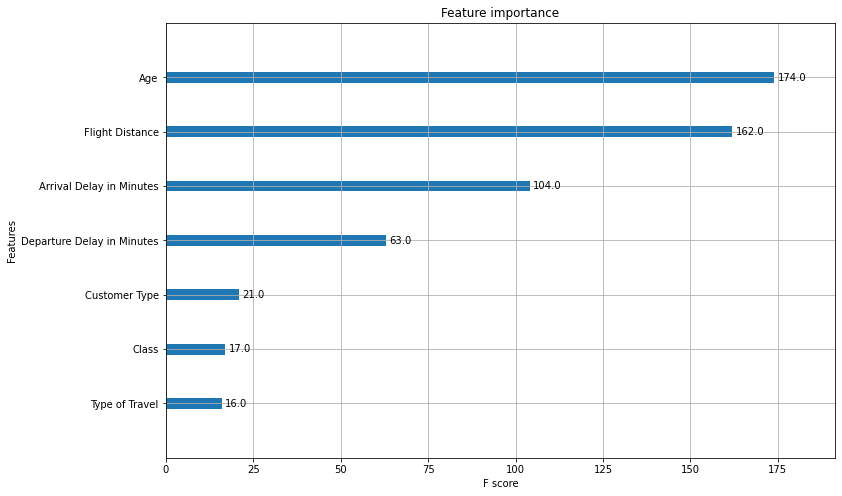

In [256]:
xgb.plot_importance(xgb_cls)

In [257]:
xgb_cls.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [258]:
%%capture
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_metric=["error", 'rmse'], eval_set=[(X_val, y_val)])

esr5 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=30, eval_metric="error", eval_set=[(X_val, y_val)])

esr30 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=50, eval_metric="error", eval_set=[(X_val, y_val)])

esr50 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=75, eval_metric="error", eval_set=[(X_val, y_val)])

esr75 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="rmse", eval_set=[(X_val, y_val)])

esr = xgb_cls.score(airline_test_x, airline_test_y)

In [259]:
print(esr5)
print(esr30)
print(esr50)
print(esr75)
print(esr)

0.8021635355712966
0.8020865414228519
0.8020865414228519
0.8020865414228519
0.8011626116415153


Wygląda na to, że od pewnej wartości `early_stopping_rounds` score zaczyna spadać, ale aż do tego momentu dokładna wartość parametru nie ma znaczenia.

In [260]:
%%capture
xgb_cls.set_params(max_depth = 4)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric="error", eval_set=[(X_val, y_val)])

md4 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.set_params(max_depth = 6)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric="error", eval_set=[(X_val, y_val)])

md6 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.set_params(max_depth = 8)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric="error", eval_set=[(X_val, y_val)])

md8 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.set_params(max_depth = 10)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric="error", eval_set=[(X_val, y_val)])

md10 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.set_params(max_depth = 12)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric="error", eval_set=[(X_val, y_val)])

md12 = xgb_cls.score(airline_test_x, airline_test_y)

In [261]:
print(md4)
print(md6)
print(md8)
print(md10)
print(md12)

0.8010856174930705
0.8020865414228519
0.802856482907299
0.8003541730828457
0.798352325223283


Zbyt małe `max_depth` prawdopodobnie prowadzi do underfittingu, a zbyt duże do overfittingu. Domyślną wartością parametru jest 6, co, jak widać na tym przykładzie, jest dość dobrą wartością. W tym przypadku nie jest jednak najlepsza.

In [262]:
%%capture
xgb_cls.set_params(n_estimators = 10)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

nest10 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.set_params(n_estimators = 100)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric="error", eval_set=[(X_val, y_val)])

nest100 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.set_params(n_estimators = 500)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=50, eval_metric="error", eval_set=[(X_val, y_val)])

nest500 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.set_params(n_estimators = 1000)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=100, eval_metric="error", eval_set=[(X_val, y_val)])

nest1000 = xgb_cls.score(airline_test_x, airline_test_y)

xgb_cls.set_params(n_estimators = 10000)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=100, eval_metric="error", eval_set=[(X_val, y_val)])

nest10000 = xgb_cls.score(airline_test_x, airline_test_y)

In [263]:
print(nest10)
print(nest100)
print(nest500)
print(nest1000)
print(nest10000)

0.798352325223283
0.798352325223283
0.7967739451801663
0.7967739451801663
0.7967739451801663


Podobnie do `max_depth`, mamy tu do czynienia z under- i overfittingiem przy małych i dużych wartościach. Powyżej `n_estimators` = 500 wygląda na to, że score osiąga wartość asymptotyczną.

#### Wybór najlepszego spośród sprawdzonych zestawu parametrów – `early_stopping_rounds` = 50, `max_depth` = 8, `n_estimators` = 500

In [264]:
%%capture
xgb_cls.set_params(n_estimators = 500, max_depth = 8)
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=50, eval_metric="error", eval_set=[(X_val, y_val)])

best = xgb_cls.score(airline_test_x, airline_test_y)

In [265]:
print(best)

0.802856482907299


## Dataset `car_prices_poland`

### Obróbka danych

In [148]:
cars.shape

(117927, 11)

In [150]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB


In [151]:
cars.describe()

,Unnamed: 0,year,mileage,vol_engine,price
count,117927.000000,117927.000000,1.179270e+05,117927.000000,1.179270e+05
mean,58963.000000,2012.925259,1.409768e+05,1812.057782,7.029988e+04
std,34042.736935,5.690135,9.236936e+04,643.613438,8.482458e+04
min,0.000000,1945.000000,0.000000e+00,0.000000,5.000000e+02
25%,29481.500000,2009.000000,6.700000e+04,1461.000000,2.100000e+04
50%,58963.000000,2013.000000,1.462690e+05,1796.000000,4.190000e+04
75%,88444.500000,2018.000000,2.030000e+05,1995.000000,8.360000e+04
max,117926.000000,2022.000000,2.800000e+06,7600.000000,2.399900e+06


<AxesSubplot:>

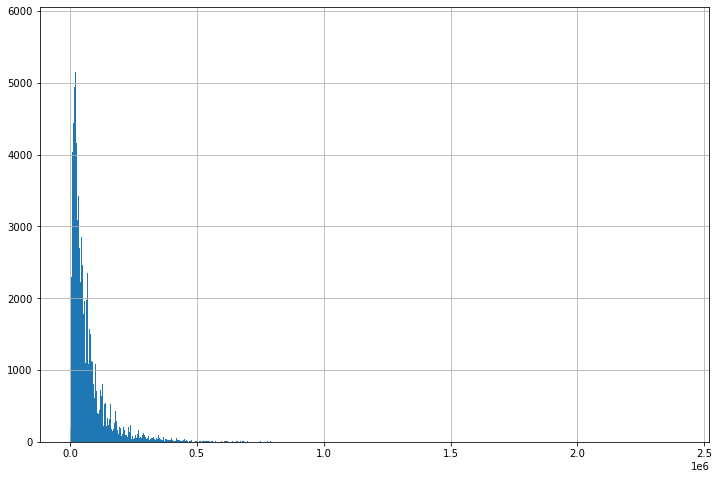

In [152]:
cars.price.hist(bins = 1000)

In [153]:
cars.corr(method = 'spearman')

,Unnamed: 0,year,mileage,vol_engine,price
Unnamed: 0,1.000000,0.101061,-0.114396,-0.141628,0.015414
year,0.101061,1.000000,-0.777957,-0.145760,0.867978
mileage,-0.114396,-0.777957,1.000000,0.263786,-0.680324
vol_engine,-0.141628,-0.145760,0.263786,1.000000,0.190013
price,0.015414,0.867978,-0.680324,0.190013,1.000000


In [154]:
cars = cars.drop('Unnamed: 0', axis = 1)

##### Podejście 1

##### Zamiana nazw miast na kategorie

In [155]:
miasta.Kategoria.value_counts()

<10k     559
>10k     312
>50k      46
>100k     26
>250k      6
>500k      5
Name: Kategoria, dtype: int64

In [156]:
miasta = miasta[['Miasto', 'Kategoria']]
miasta.columns = ['city', 'category']

In [157]:
miasta.head()

,city,category
0,Aleksandrów Kujawski,>10k
1,Aleksandrów Łódzki,>10k
2,Alwernia,<10k
3,Andrychów,>10k
4,Annopol,<10k


In [158]:
cars = pd.merge(left = cars, right = miasta, how = 'left', left_on = 'city', right_on = 'city')

In [159]:
cars['category'] = cars.apply(lambda x: '<10k' if pd.isna(x['category']) == True else x['category'], axis = 1)

Miejscowości, których nie było w ramce, prawdopodobnie są bardzo małe, więc ustawiam ich kategorię na `<10k`.

In [161]:
cars['category'] = cars['category'].map({
    '<10k' : 1,
    '>10k' : 2,
    '>50k' : 3,
    '>100k' : 4,
    '>250k' : 5,
    '>500k' : 6
})

In [162]:
cars.head()

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,category
0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900,1
1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501,5
2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000,2
3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800,1
4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900,3


In [163]:
cars = cars.drop('city', axis = 1)

Zamieniam rekordy bez wartości `generation_name` na kategorię `other`, bo jest ich znacznie więcej niż innych nazwanych kategorii, więc nie można się ich pozbyć.

In [164]:
cars[cars.generation_name.isna() == True].shape[0]

30130

In [165]:
cars['generation_name'] = cars.apply(lambda x: 'other' if isinstance(x['generation_name'], str) == False else x['generation_name'], axis = 1)

In [166]:
cars.fuel.unique()

array(['Diesel', 'CNG', 'Gasoline', 'LPG', 'Hybrid', 'Electric'],
      dtype=object)

In [167]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(cars[['mark', 'model', 'generation_name', 'province', 'fuel']]).toarray())
cars = cars.join(encoder_df)
cars = cars.drop(['mark', 'model', 'generation_name', 'province', 'fuel'], axis = 1)

In [168]:
cars.shape

(118163, 750)

### Random forest

In [169]:
y = cars.price
cars = cars.drop('price', axis = 1)
X_train, X_val, y_train, y_val = train_test_split(cars, y, test_size=0.3)

#### Wpływ `n_estimators` na wynik

In [170]:
rf = RandomForestRegressor(
                            n_estimators = 10,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9136644730593637


In [171]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9230450359650959


In [172]:
rf = RandomForestRegressor(
                            n_estimators = 300,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9239502112883892


#### Wpływ `max_depth` na wynik

In [173]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = 2,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.15309086218349155


In [174]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = 6,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.4136884016484518


In [175]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = 10,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.5988575817105766


In [176]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = 16,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.7550600482865643


In [177]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = None,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9230450359650959


Mamy na tyle dużo zmiennych, że wygląda na to że warto dać drzewom rozrastać się tak długo jak chcą, bo podnosi to score.

In [178]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = None,
                            max_features = 'log2',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.918928507788879


In [179]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = None,
                            max_features = None,
                            random_state = 17
)

print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9307401996845251


Najlepsze wyniki otrzymujemy z `n_estimators` = 100, `max_depth` = None i `max_features` = None (czyli bez ograniczeń przy wyborze kolumn).

### XGBoost

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125)

In [181]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", use_label_encoder=False)

#### Wpływ `n_estimators` na wynik

In [182]:
%%capture
xgb_reg.set_params(n_estimators = 10)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [183]:
xgb_reg.score(X_val, y_val)

0.894704800945457

In [184]:
%%capture
xgb_reg.set_params(n_estimators = 100)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [185]:
xgb_reg.score(X_val, y_val)

0.9268406441195025

In [186]:
%%capture
xgb_reg.set_params(n_estimators = 500)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [187]:
xgb_reg.score(X_val, y_val)

0.9298541975318171

#### Wpływ `max_depth` na wynik

In [188]:
%%capture
xgb_reg.set_params(n_estimators = 100, max_depth = 2)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [189]:
xgb_reg.score(X_val, y_val)

0.8842091841794509

In [190]:
%%capture
xgb_reg.set_params(max_depth = 8)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [191]:
xgb_reg.score(X_val, y_val)

0.9310721087354805

In [192]:
%%capture
xgb_reg.set_params(max_depth = 16)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [193]:
xgb_reg.score(X_val, y_val)

0.9286338050359628

In [194]:
%%capture
xgb_reg.set_params(max_depth = None)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [195]:
xgb_reg.score(X_val, y_val)

0.9286338050359628

Najlepsze wyniki osiągam dla `n_estimators` = 500 i `max_depth` = 8.

In [196]:
%%capture
xgb_reg.set_params(n_estimators = 500, max_depth = 8)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [197]:
xgb_reg.score(X_val, y_val)

0.9339199423290979

##### Podejście 2

##### Zastosowanie one-hot encoding na kolumnie miast

In [198]:
cars = pd.read_csv("./data/car_prices_poland/Car_Prices_Poland.csv")

In [199]:
cars = cars.drop('Unnamed: 0', axis = 1)

In [200]:
cars.city.value_counts()

Warszawa         7972
Łódź             3341
Kraków           2936
Wrocław          2764
Poznań           2382
                 ... 
Słopsk              1
Giełczyn            1
Strumyk             1
Czestków F          1
Kraśnik Dolny       1
Name: city, Length: 4427, dtype: int64

Jest bardzo dużo unikalnych miast, zamienię część z nich o najmniejszej częstości występowania na kategorię `other`.

In [201]:
cities_to_other = pd.DataFrame(cars.city.value_counts())
cities_to_other = cities_to_other[cities_to_other['city'] <= 50].reset_index()['index']

cities_to_other = list(cities_to_other)

cars.city = cars.apply(lambda x: 'other' if x['city'] in cities_to_other else x['city'], axis = 1)

In [202]:
cars.city.value_counts()

other       22251
Warszawa     7972
Łódź         3341
Kraków       2936
Wrocław      2764
            ...  
Paczkowo       51
Klaudyn        51
Knurów         51
Miechów        51
Błonie         51
Name: city, Length: 350, dtype: int64

In [203]:
cars[cars.generation_name.isna() == True].shape[0]

30085

Zamieniam rekordy bez wartości `generation_name` na kategorię `other`, bo jest ich znacznie więcej niż innych nazwanych kategorii, więc nie można się ich pozbyć.

In [204]:
cars['generation_name'] = cars.apply(lambda x: 'other' if isinstance(x['generation_name'], str) == False else x['generation_name'], axis = 1)

In [205]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(cars[['mark', 'model', 'generation_name', 'city', 'province', 'fuel']]).toarray())
cars = cars.join(encoder_df)
cars = cars.drop(['mark', 'model', 'generation_name', 'city', 'province', 'fuel'], axis = 1)

### Random forest

In [206]:
y = cars.price
cars = cars.drop('price', axis = 1)
X_train, X_val, y_train, y_val = train_test_split(cars, y, test_size=0.3)

#### Wpływ `n_estimators` na wynik

In [208]:
rf = RandomForestRegressor(
                            n_estimators = 10,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9335169712353752


In [209]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9440835667902296


In [210]:
rf = RandomForestRegressor(
                            n_estimators = 300,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9451005899791806


#### Wpływ `max_depth` na wynik

In [211]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = 2,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.1364300493520979


In [212]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = 6,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.34442675300006775


In [213]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = 10,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.5299334658048596


In [214]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = 16,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.7184809173229444


In [215]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = None,
                            max_features = 'sqrt',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9440835667902296


Sprawdzam inne wartości `max_features`.

In [216]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = None,
                            max_features = 'log2',
                            random_state = 17
)
print(rf.fit(X_train, y_train).score(X_val, y_val))

0.9363137239321804


In [217]:
rf = RandomForestRegressor(
                            n_estimators = 100,
                            max_depth = None,
                            max_features = None,
                            random_state = 17
)

print(rf.fit(X_train, y_train).score(X_val, y_val))

0.944587758594579


### XGBoost

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125)

In [219]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", use_label_encoder=False)

#### Wpływ `n_estimators` na wynik

In [220]:
%%capture
xgb_reg.set_params(n_estimators = 10)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [221]:
xgb_reg.score(X_val, y_val)

0.9115155351464613

In [222]:
%%capture
xgb_reg.set_params(n_estimators = 100)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [223]:
xgb_reg.score(X_val, y_val)

0.9396538382591455

In [224]:
%%capture
xgb_reg.set_params(n_estimators = 500)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [225]:
xgb_reg.score(X_val, y_val)

0.9451351993837036

#### Wpływ `max_depth` na wynik

In [226]:
%%capture
xgb_reg.set_params(n_estimators = 100, max_depth = 2)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [227]:
xgb_reg.score(X_val, y_val)

0.9014600926549413

In [228]:
%%capture
xgb_reg.set_params(max_depth = 8)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [229]:
xgb_reg.score(X_val, y_val)

0.9427537419250528

In [230]:
%%capture
xgb_reg.set_params(max_depth = 16)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [231]:
xgb_reg.score(X_val, y_val)

0.9407140677702152

In [232]:
%%capture
xgb_reg.set_params(max_depth = None)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [233]:
xgb_reg.score(X_val, y_val)

0.9407140677702152

Najlepsze wyniki osiągam osobno dla `n_estimators` = 500 i `max_depth` = 8.

In [234]:
%%capture
xgb_reg.set_params(n_estimators = 500, max_depth = 8)
xgb_reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [235]:
xgb_reg.score(X_val, y_val)

0.9443136908661456

Widać jednak, że lepszy score uzyskałem dla `n_estimators` = 500 i `max_depth` = None, był on równy 0.9451351993837036. Widać wyraźnie, że drugie podejście dało lepsze wyniki niż pierwsze.

## Wnioski

Wszystkie sprawdzone przeze mnie parametry zauważalnie wpływają na wartość score przy odpowiednich modelach. W obu scenariuszach lepiej sprawdził się XGBoost, ale wyniki są na tyle zbliżone, że dokładne dobranie odpowiednich mogłoby to potencjalnie odwrócić.